In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, LayerType, System, plot_loss_df

## Model 1
$$\frac{d x}{d t} = 2 * t, x(0)=1$$
Solution: $x(t)=t^2 + 1$

In [2]:
ode1 = PDEModel("ode1", config={"num_epochs": 100, "lr": 1, "loss_log_interval": 10})
ode1.set_state(["t"], {"t": [-2., 2.]})
ode1.add_endog("x", {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "hidden_units": [1, 2, 2, 1],
    "layer_type": LayerType.KAN,
    "activation_type": ActivationType.SiLU,
    "positive": False,
    "derivative_order": 2,
})
ode1.add_endog_equation(r"$\frac{\partial x}{\partial t} = 2 * t$", label="base_ode")
ode1.add_endog_condition("x", 
                              "x(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "1", {},
                              label="initial_condition")
print(ode1)
ode1.train_model("./models/ode1", "ode1.pt", True)
ode1.eval_model(True)

=============================Summary of Model ode1==============================
Config: {
 "batch_size": 100,
 "num_epochs": 100,
 "lr": 1,
 "loss_log_interval": 10,
 "optimizer_type": "AdamW"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
t: [-2.0, 2.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: x
EndogVar(
  (model): KAN(
    (biases): ModuleList(
      (0-1): 2 x Linear(in_features=2, out_features=1, bias=False)
      (2): Linear(in_features=1, out_features=1, bias=False)
    )
    (act_fun): ModuleList(
      (0-2): 3 x KANLayer(
        (base_fun): SiLU()
      )
    )
    (base_fun): SiLU()
    (symbolic_fun): ModuleList(
      (0-2): 3 x Symbolic_KANLayer()
    )

D:\UofT\Research\PDE-work\continuous-time-eco-models\deep_macrofin\models\kan\KAN.py:329: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


====================================Training====================================


Total loss: 0.0131: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]

training finished, total time :: 28.063508987426758
Best model saved to ./models/ode1/ode1_best.pt if valid
Model saved to ./models/ode1/ode1.pt
===================================Evaluating===================================
loss :: endogeq_base_ode: 0.0063,
endogvar_x_cond_initial_condition: 0.0000,
total_loss: 0.0063


OrderedDict([('endogeq_base_ode', tensor(0.0063, grad_fn=<MeanBackward0>)),
             ('endogvar_x_cond_initial_condition',
              tensor(8.3569e-08, grad_fn=<MeanBackward0>)),
             ('total_loss', tensor(0.0063, grad_fn=<AddBackward0>))])

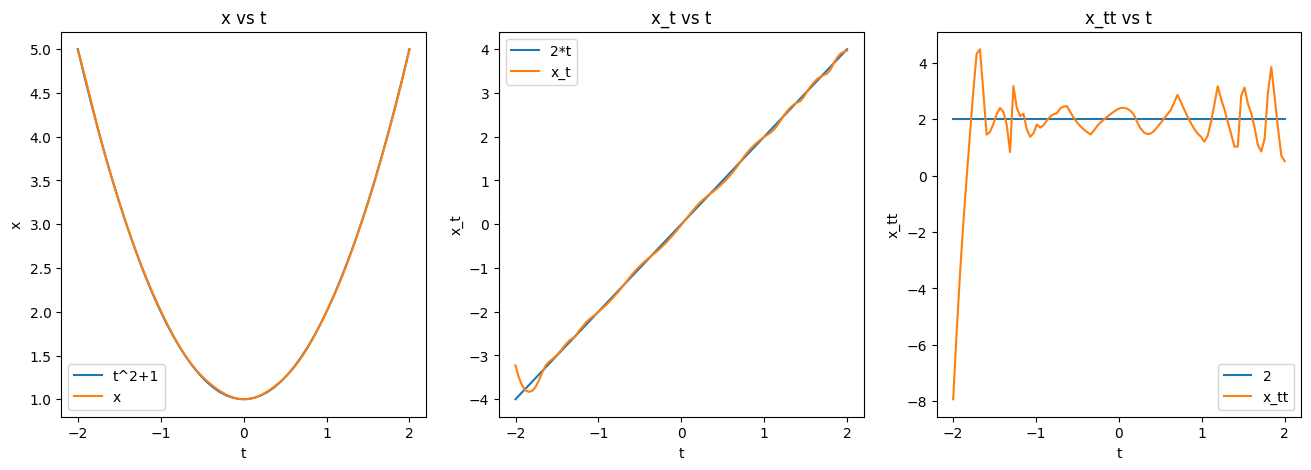

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
t = np.linspace(-2, 2)
ax[0].plot(t, t**2+1, label="t^2+1")
ax[1].plot(t, 2*t, label="2*t")
ax[2].plot(t, np.ones_like(t) * 2, label="2")
ode1.endog_vars["x"].plot("x", {"t": [-2, 2]}, ax=ax[0])
ode1.endog_vars["x"].plot("x_t", {"t": [-2, 2]}, ax=ax[1])
ode1.endog_vars["x"].plot("x_tt", {"t": [-2, 2]}, ax=ax[2])
plt.subplots_adjust()
plt.show()

## Exponential Function 
$$y=(1+2x)e^{-2x}$$

This is the function that the ODE version is not able to solve properly

In [4]:
exp_approx = PDEModel("exp_approximator", {"num_epochs": 2000})
exp_approx.set_state(["x"], {"x": [-1., 1.]})
exp_approx.add_endog("y", {
    "hidden_units": [40, 40],
})
exp_approx.add_endog_equation(r"$y=(1+2*x)*e^{-2*x}$", label="base_func")
print(exp_approx)
exp_approx.train_model("./models/exp_approx", "exp_approx.pt", True)
exp_approx.eval_model(True)

=======================Summary of Model exp_approximator========================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "AdamW"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
x: [-1.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: y
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=40, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=40, out_features=40, bias=True)
    (activation_1): Tanh()
    (final_layer): Linear(in_features=40, out_features=1, bias=True)
  )
)
Num parameters: 1761
--------------------------------------------------------

Total loss: 0.0010: 100%|██████████| 2000/2000 [00:07<00:00, 271.08it/s]

training finished, total time :: 7.383808851242065
Best model saved to ./models/exp_approx/exp_approx_best.pt if valid
Model saved to ./models/exp_approx/exp_approx.pt
===================================Evaluating===================================
loss :: endogeq_base_func: 0.0002,
total_loss: 0.0002


OrderedDict([('endogeq_base_func', tensor(0.0002, grad_fn=<MeanBackward0>)),
             ('total_loss', tensor(0.0002, grad_fn=<AddBackward0>))])

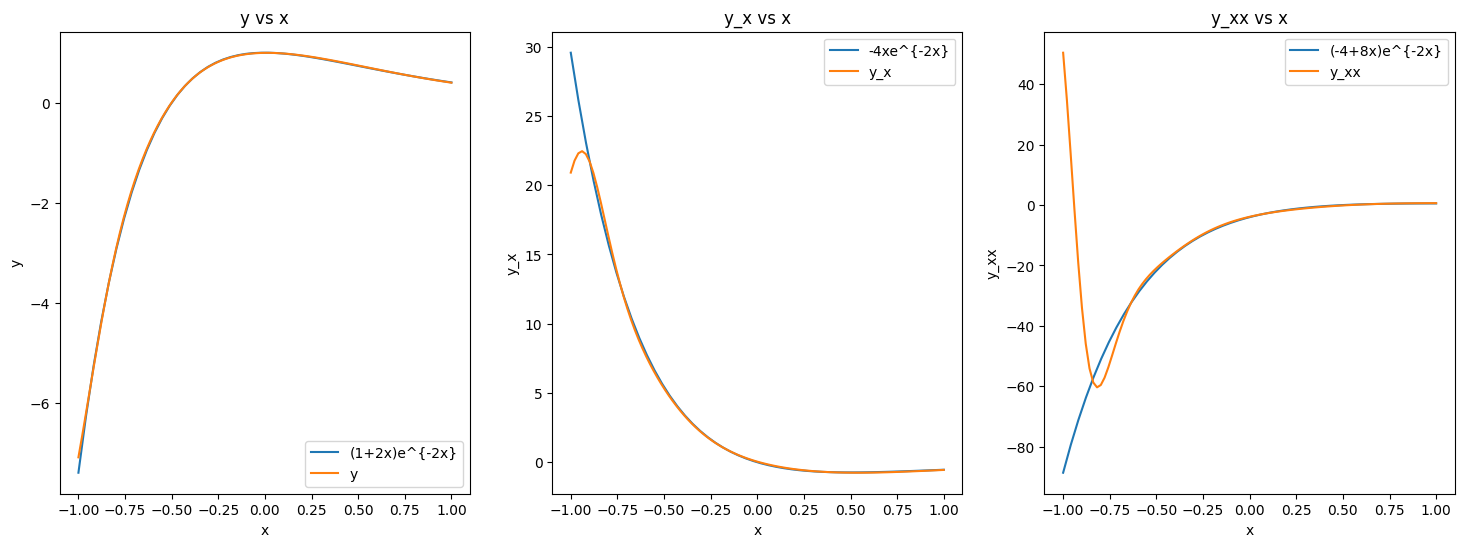

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
x = np.linspace(-1, 1)
ax[0].plot(x, (1 + 2 * x) * np.exp(-2*x), label="(1+2x)e^{-2x}")
ax[1].plot(x, -4 * x * np.exp(-2*x), label="-4xe^{-2x}")
ax[2].plot(x, (-4 + 8 * x) * np.exp(-2*x), label="(-4+8x)e^{-2x}")
exp_approx.endog_vars["y"].plot("y", {"x": [-1, 1]}, ax=ax[0])
exp_approx.endog_vars["y"].plot("y_x", {"x": [-1, 1]}, ax=ax[1])
exp_approx.endog_vars["y"].plot("y_xx", {"x": [-1, 1]}, ax=ax[2])
plt.subplots_adjust()
plt.show()

In [6]:
discont_approx = PDEModel("discontinuous_approximator", {"num_epochs": 10000})
discont_approx.set_state(["x"], {"x": [-3., 3.]})
discont_approx.add_endog("y", {
    "hidden_units": [40, 40],
})
neg_sys = System([Constraint("x", Comparator.LT, "0", label="neg_const")], label="neg_sys")
neg_sys.add_endog_equation("y=x+1")
pos_sys = System([Constraint("x", Comparator.GEQ, "0", label="pos_const")], label="pos_sys")
pos_sys.add_endog_equation("y=x**2")
discont_approx.add_system(neg_sys)
discont_approx.add_system(pos_sys)
print(discont_approx)
discont_approx.train_model("./models/discont_approx", "discont_approx.pt", True)
discont_approx.eval_model(True)

==================Summary of Model discontinuous_approximator===================
Config: {
 "batch_size": 100,
 "num_epochs": 10000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "AdamW"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
x: [-3.0, 3.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: y
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=40, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=40, out_features=40, bias=True)
    (activation_1): Tanh()
    (final_layer): Linear(in_features=40, out_features=1, bias=True)
  )
)
Num parameters: 1761
-------------------------------------------------------

Total loss: 0.0001: 100%|██████████| 10000/10000 [00:45<00:00, 221.15it/s]

training finished, total time :: 45.22335171699524
Best model saved to ./models/discont_approx/discont_approx_best.pt if valid
Model saved to ./models/discont_approx/discont_approx.pt
===================================Evaluating===================================
loss :: system_neg_sys: 0.0000,
system_pos_sys: 0.0001,
total_loss: 0.0001


OrderedDict([('system_neg_sys', tensor(4.0058e-05, grad_fn=<AddBackward0>)),
             ('system_pos_sys', tensor(5.7465e-05, grad_fn=<AddBackward0>)),
             ('total_loss', tensor(9.7523e-05, grad_fn=<AddBackward0>))])

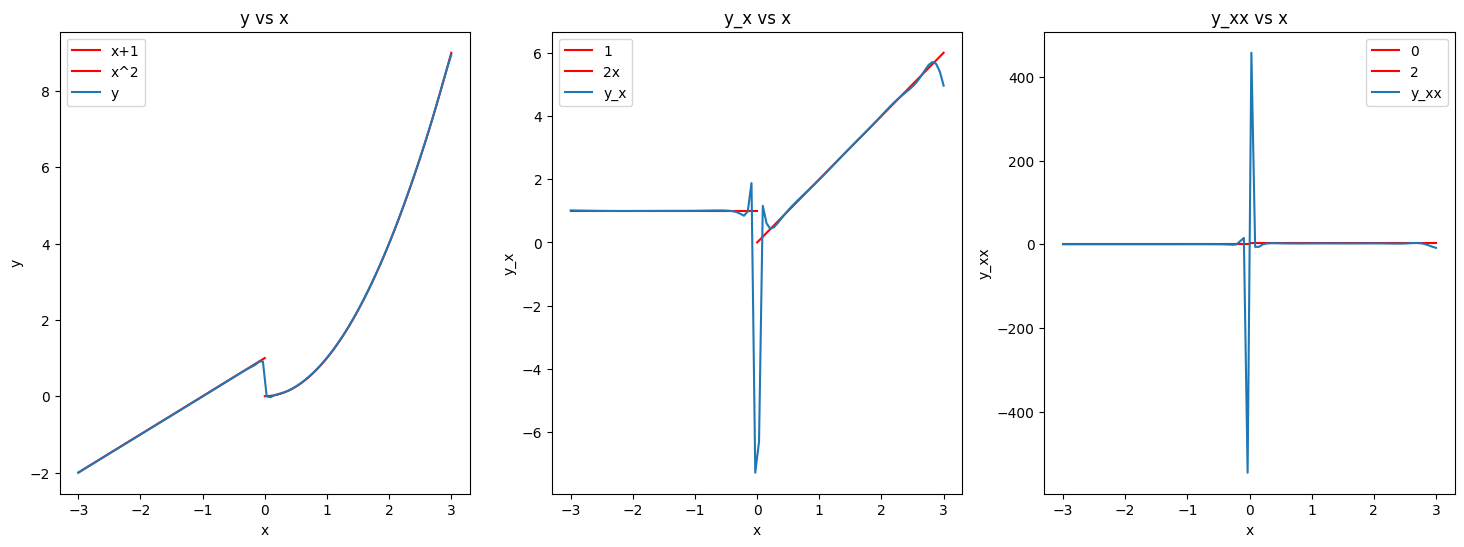

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
x = np.linspace(-3, 3)
x_neg = np.linspace(-3, 0)
x_pos = np.linspace(0, 3)
ax[0].plot(x_neg, x_neg + 1, label="x+1", color="red")
ax[0].plot(x_pos, x_pos**2, label="x^2", color="red")
ax[1].plot(x_neg, np.ones_like(x_neg), label="1", color="red")
ax[1].plot(x_pos, 2*x_pos, label="2x", color="red")
ax[2].plot(x_neg, np.zeros_like(x_neg), label="0", color="red")
ax[2].plot(x_pos, 2*np.ones_like(x_pos), label="2", color="red")
discont_approx.endog_vars["y"].plot("y", {"x": [-3, 3]}, ax=ax[0])
discont_approx.endog_vars["y"].plot("y_x", {"x": [-3, 3]}, ax=ax[1])
discont_approx.endog_vars["y"].plot("y_xx", {"x": [-3, 3]}, ax=ax[2])
plt.subplots_adjust()
plt.show()

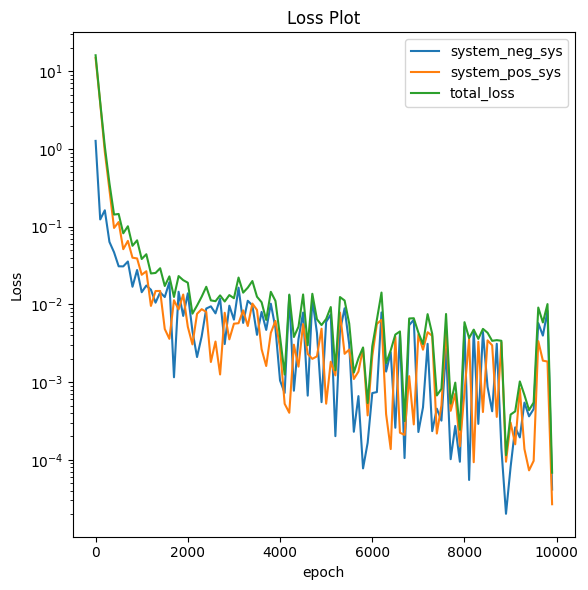

In [8]:
plot_loss_df(fn="./models/discont_approx/discont_approx_loss.csv", loss_plot_fn="./models/discont_approx/discont_approx_loss.png")